# Imports 

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import torch
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [3]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 62592
    })
})


## Split dataset

In [4]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
62587  An email released by WikiLeaks on Sunday appea...      1           0   
62588  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
62589  You know, because in fantasyland Republicans n...      1           0   
62590  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
62591  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   

       has_url  percent_uppercase  frequency_punctu

In [5]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label", "text"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

display(x_train)
display(y_train)

,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
6312,0,1,3.210369,107,16.231306,0,1,0,13,17.958333,0,1,0,0,0,4.823389,0.498807,0.427208
1575,0,1,2.939735,46,16.217540,0,0,5,2,20.470588,1,0,0,0,1,4.908555,0.592920,0.418879
34150,0,0,2.004385,49,16.630128,0,1,2,5,23.125000,0,0,0,0,0,4.958254,0.550285,0.413662
20440,0,1,4.370962,47,15.925504,0,0,3,7,21.950000,1,0,0,0,0,5.023364,0.553738,0.401869
49987,0,0,3.140559,178,17.387974,0,0,4,22,16.837209,0,0,0,0,0,4.652239,0.426866,0.466418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12895,0,1,2.826433,42,16.281847,1,0,4,5,17.360000,1,0,0,0,0,4.942446,0.565947,0.484412
60960,0,1,2.833112,46,16.688800,0,0,5,7,18.136364,0,1,0,0,1,4.806283,0.570681,0.476440
6012,0,1,13.148148,30,16.481481,1,0,2,3,18.800000,1,0,0,3,0,4.844444,0.733333,0.388889
6558,1,1,2.282755,131,17.015154,1,0,2,9,19.872340,1,0,0,0,0,4.510293,0.431203,0.489707


6312     1
1575     1
34150    0
20440    0
49987    0
        ..
12895    1
60960    1
6012     1
6558     0
56267    1
Name: label, Length: 50073, dtype: int64

NB multinomial needs numeric, remove non numerics

Only run this if future parts have ERRORS regarding numeric (unclean input)

In [ ]:
# Convert dataset to pandas for easier implementation with sklearn
df = dataset["train"].to_pandas()
print("Dataset columns:", df.columns)
print("Data types:", df.dtypes)

# Check for any non-numeric values that might cause problems
for col in df.columns:
    if df[col].dtype == 'object':  # Check if column contains strings
        print(f"Column {col} contains non-numeric data and will be dropped")
        df = df.drop(columns=[col])

# Make sure all remaining columns are numeric
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError as e:
        print(f"Error converting column {col}: {e}")
        # If conversion fails, we'll examine the problematic values
        problematic_rows = df[~pd.to_numeric(df[col], errors='coerce').notna()]
        if not problematic_rows.empty:
            print(f"Sample of problematic values in {col}:")
            print(problematic_rows[col].head())
            # Drop the problematic column if we can't convert it
            df = df.drop(columns=[col])

print("Final columns after cleaning:", df.columns)

### Training

no further preprocessing

In [6]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

Convert Negative values to 0 and scale features to [0,1]

In [7]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Initialize and train multinomialNB classifier

In [8]:
nb_multinomial = MultinomialNB()
nb_multinomial.fit(x_train_scaled, y_train)

MultinomialNB()

In [9]:
# Make predictions
y_pred = nb_multinomial.predict(x_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.652128764278297


In [10]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73      6984
           1       0.66      0.43      0.52      5535

    accuracy                           0.65     12519
   macro avg       0.66      0.63      0.62     12519
weighted avg       0.65      0.65      0.64     12519



In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[5786 1198]
 [3157 2378]]


## Visualize feature importance

examine log probabilities for naive Bayes ( not a tree )

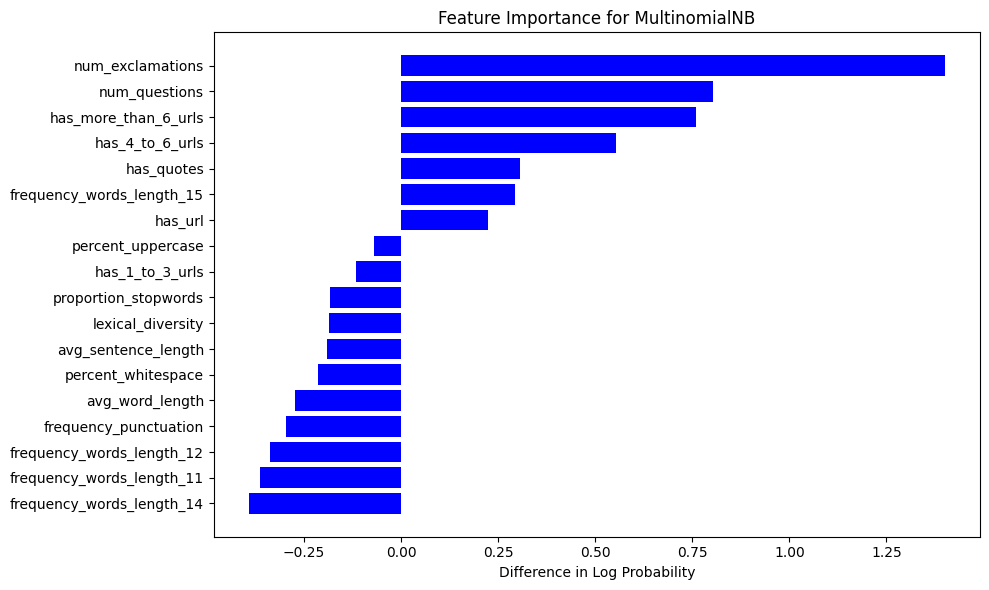

In [12]:
feature_importance = nb_multinomial.feature_log_prob_[1] - nb_multinomial.feature_log_prob_[0]
feature_names = x_train.columns

# Sort features by importance
indices = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.title('Feature Importance for MultinomialNB')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Difference in Log Probability')
plt.tight_layout()
plt.show()

## Cross Validation

## Hyperparameter tuning

In [13]:
# RandomizedSearchCV for MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define parameter distribution for MultinomialNB
param_dist = {'alpha': uniform(0.001, 10)}  # Randomly sample alpha values between 0.001 and 10

# Use RandomizedSearchCV to find the best hyperparameters
rand_search = RandomizedSearchCV(MultinomialNB(), 
                                 param_distributions=param_dist, 
                                 n_iter=20, 
                                 cv=5, 
                                 n_jobs=-1, 
                                 random_state=seed)

# Fit the random search object to the data
rand_search.fit(x_train_scaled, y_train)


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000027F2B5D8760>},
                   random_state=45)

## Tuning alpha parameter with cross-validation

run only if we want to use grid search

In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Set up GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

Compare the parameters

In [15]:
# Print best parameters
print("\nBest parameters found: ", rand_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(rand_search.best_score_))


Best parameters found:  {'alpha': np.float64(0.773895660791727)}
Best cross-validation accuracy: 0.6440


In [16]:
# print randomized search results
print("\nBest parameters found by RandomizedSearchCV: ", rand_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(rand_search.best_score_))


Best parameters found by RandomizedSearchCV:  {'alpha': np.float64(0.773895660791727)}
Best cross-validation accuracy: 0.6440


Evaluate model with best parameters

In [17]:
best_nb = rand_search.best_estimator_
y_pred_best = best_nb.predict(x_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))

Test accuracy with best parameters: 0.6521


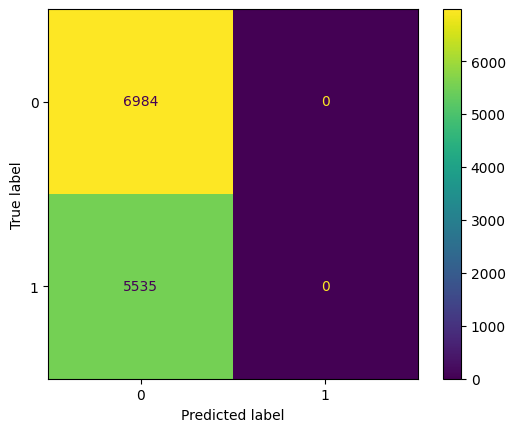

In [18]:
# Generate predictions with the best model
y_pred = best_nb.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

Save the results

In [19]:
import json
import os
from datetime import datetime

# Create a dictionary to store all results
results = {
    "model_name": "MultinomialNB_iter2",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "dataset": "WELFake_stylo_feats",
    "metrics": {
        "accuracy": float(accuracy),
        "best_accuracy": float(accuracy_best),
        "best_alpha": rand_search.best_params_["alpha"],
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": {}
    },
    "feature_importance": {feature: float(importance) for feature, importance in 
                          zip(feature_names, feature_importance)}
}

# Get classification report metrics
report = classification_report(y_test, y_pred, output_dict=True)
for class_label, metrics in report.items():
    if isinstance(metrics, dict):
        results["metrics"]["classification_report"][class_label] = {
            k: float(v) for k, v in metrics.items()
        }

# Ensure the results directory exists
if not os.path.exists('model_results'):
    os.makedirs('model_results')

# Save the results to a JSON file
filename = f"model_results/nb_multinomial_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {filename}")

Results saved to model_results/nb_multinomial_results_20250421_184634.json


# K-Fold Validation

In [20]:
from sklearn.model_selection import cross_val_score, KFold

# Setup k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create a new MultinomialNB classifier with the best alpha from rand search
best_alpha = rand_search.best_params_['alpha']
nb_cv = MultinomialNB(alpha=best_alpha)

# Perform k-fold cross-validation
cv_scores = cross_val_score(nb_cv, x_train_scaled, y_train, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f"K-fold Cross-Validation Results ({k_folds} folds):")
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

# Train the final model on the entire training dataset
nb_final = MultinomialNB(alpha=best_alpha)
nb_final.fit(x_train_scaled, y_train)

K-fold Cross-Validation Results (5 folds):
CV Accuracy: 0.6440 ± 0.0027
Individual fold scores: [0.6441338  0.64343485 0.64782826 0.64519672 0.63960455]


MultinomialNB(alpha=np.float64(0.773895660791727))

# Test on the gossicop dataset

In [21]:
# Load the external test dataset
from datasets import load_dataset
import pandas as pd
import numpy as np

test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")

In [22]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


y_test_set = test_df["label"]
x_test_set = test_df.drop(labels=["label", "text"], axis=1)

display(x_test_set)
display(y_test_set)

,text,label,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,The media reported on “5 TikTok dances you can...,0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,"""Over 240,000 'unverified' ballots have alread...",0,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,"Says ""Ron Johnson is making excuses for rioter...",1,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,“We have seen over the last 10 years ... under...,0,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,“I don’t get involved in the hiring and firing...,0,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


0       0
1       0
2       1
3       0
4       0
       ..
6895    0
6896    0
6897    0
6898    0
6899    0
Name: label, Length: 6900, dtype: int64

In [23]:
y_test_pred = best_nb.predict(x_test_set)
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6617391304347826
Precision: 0.3333333333333333
Recall: 0.0008576329331046312


# Feature Selection

In [24]:
from sklearn.feature_selection import SelectKBest, f_classif

# Remove the text column if present in your x_train dataset
features_for_selection = x_train.drop('text', axis=1, errors='ignore')

# Define the number of top features to select
num_features = 5  # You can adjust this number

# Use SelectKBest to identify top features
selector = SelectKBest(f_classif, k=num_features)
selector.fit(features_for_selection, y_train)

# Get selected feature indices and names
selected_indices = selector.get_support(indices=True)
selected_features = features_for_selection.columns[selected_indices]

print(f"\nTop {num_features} selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature} (Score: {selector.scores_[selected_indices[i]]:.2f})")

# Create datasets with only selected features
X_train_selected = features_for_selection.iloc[:, selected_indices]
X_test_selected = x_test.drop('text', axis=1, errors='ignore').iloc[:, selected_indices]

# Scale the selected features
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Train and evaluate model with selected features
nb_selected = MultinomialNB(alpha=best_alpha)
nb_selected.fit(X_train_selected_scaled, y_train)
selected_predictions = nb_selected.predict(X_test_selected_scaled)

# Evaluate performance with selected features
selected_accuracy = accuracy_score(y_test, selected_predictions)
selected_report = classification_report(y_test, selected_predictions)

print("\nPerformance with selected features:")
print(f"Accuracy: {selected_accuracy:.4f}")
print("Classification Report:")
print(selected_report)


Top 5 selected features:
1. has_url (Score: 4443.98)
2. has_4_to_6_urls (Score: 1429.12)
3. has_more_than_6_urls (Score: 1690.81)
4. num_questions (Score: 1266.73)
5. avg_word_length (Score: 2104.62)

Performance with selected features:
Accuracy: 0.6100
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.93      0.73      6984
           1       0.71      0.20      0.31      5535

    accuracy                           0.61     12519
   macro avg       0.65      0.57      0.52     12519
weighted avg       0.64      0.61      0.54     12519



## Recursive feature Elimination

In [25]:
from sklearn.feature_selection import RFE
import pandas as pd

def recursive_feature_pruning(model, x, y, num_features_to_select=None):

    rfe = RFE(estimator=model, n_features_to_select=num_features_to_select or 1, step=1)
    rfe.fit(x, y)

    # Get selected features
    selected_features = x.columns[rfe.support_]
    
    # Get ranking of features
    feature_ranking = pd.DataFrame({
        'feature': x.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')

    return selected_features.tolist(), feature_ranking


In [26]:
from sklearn.linear_model import LogisticRegression

# Use LogisticRegression as the estimator for RFE
logistic_model = LogisticRegression(max_iter=1000, random_state=seed)

# Perform recursive feature elimination
top_features, ranking_df = recursive_feature_pruning(logistic_model, x_train, y_train, num_features_to_select=10)

print("Selected Top Features:")
print(top_features)

print("\nFeature Rankings:")
print(ranking_df)


Selected Top Features:
['has_quotes', 'has_url', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords']

Feature Rankings:
                      feature  rank
0                  has_quotes     1
1                     has_url     1
15            avg_word_length     1
14              num_questions     1
12       has_more_than_6_urls     1
13           num_exclamations     1
10            has_1_to_3_urls     1
11            has_4_to_6_urls     1
17       proportion_stopwords     1
16          lexical_diversity     1
4          percent_whitespace     2
9         avg_sentence_length     3
5   frequency_words_length_15     4
2           percent_uppercase     5
8   frequency_words_length_11     6
7   frequency_words_length_12     7
3       frequency_punctuation     8
6   frequency_words_length_14     9


## Train with top features after Recursive Feature Elimination

In [27]:
display(x_train[top_features])

,has_quotes,has_url,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
6312,0,1,0,1,0,0,0,4.823389,0.498807,0.427208
1575,0,1,1,0,0,0,1,4.908555,0.592920,0.418879
34150,0,0,0,0,0,0,0,4.958254,0.550285,0.413662
20440,0,1,1,0,0,0,0,5.023364,0.553738,0.401869
49987,0,0,0,0,0,0,0,4.652239,0.426866,0.466418
...,...,...,...,...,...,...,...,...,...,...
12895,0,1,1,0,0,0,0,4.942446,0.565947,0.484412
60960,0,1,0,1,0,0,1,4.806283,0.570681,0.476440
6012,0,1,1,0,0,3,0,4.844444,0.733333,0.388889
6558,1,1,1,0,0,0,0,4.510293,0.431203,0.489707


In [28]:
# Create and train a new model using only the top_features
nb_rfe = MultinomialNB(alpha=rand_search.best_params_['alpha'])
nb_rfe.fit(x_train[top_features], y_train)

# Now you can make predictions with this model
y_pred_rfe = nb_rfe.predict(x_test[top_features])

# Then evaluate the performance
accuracy = accuracy_score(y_test, y_pred_rfe)
precision = precision_score(y_test, y_pred_rfe)
recall = recall_score(y_test, y_pred_rfe)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6735362249380941
Precision: 0.735217673814165
Recall: 0.4088527551942186


In [29]:
# Re-run RandomizedSearchCV on only the selected features
rand_search_rfe = RandomizedSearchCV(MultinomialNB(), 
                                    param_distributions=param_dist, 
                                    n_iter=20, 
                                    cv=5, 
                                    n_jobs=-1, 
                                    random_state=seed)

# Fit on the reduced feature set
rand_search_rfe.fit(x_train[top_features], y_train)

# Get the best model and make predictions
best_nb_multinomial_rfe = rand_search_rfe.best_estimator_
y_pred_rfe = best_nb_multinomial_rfe.predict(x_test[top_features])



# Save Model

In [31]:
import pickle

pickle.dump(best_nb, open("model_results/iter2_nb_multinomial_allfeats", 'wb'))